# Before you start:
Here are some simple scripts for you to valid your cuda installation.

In [1]:
import torch
print(torch.__version__) # 2.6.0+cu118
print(torch.version.cuda) # 11.8
print(torch.backends.cudnn.version()) # 90100

2.6.0+cu118
11.8
90100


In [2]:
import torch
print(torch.version.cuda)                 # 11.8
print(torch.cuda.is_available())          # True
print(torch.cuda.device_count())          # >= 1
print(torch.cuda.get_device_name(0))      # Name of the GPU

11.8
True
1
NVIDIA GeForce RTX 2070 with Max-Q Design


Here, we set the random seeds to be fixed.

In [3]:
import os
import random
import numpy as np
import torch

def set_seed(seed: int = 42):
    """Fix random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU

    # Make cuDNN deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Task2-1: Preprocessor

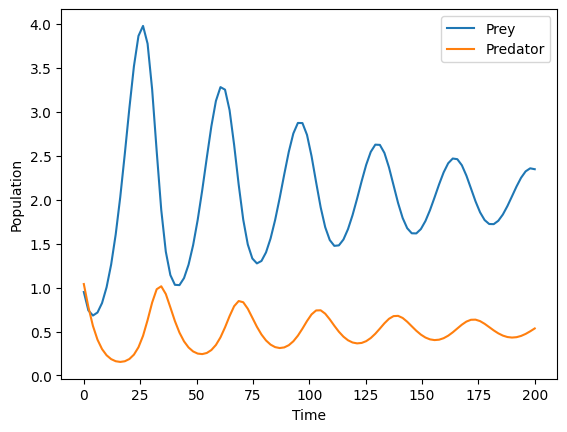

In [5]:
"""
    Visualization of the data structure

• /trajectories: Main dataset array of shape (1000, 100, 2)
    - 1000 different predator-prey systems (first dimension)
    - 100 time points per system (second dimension)
    - 2 population variables (third dimension: [:,:,0] = prey, [:,:,1] = predator)
• /time: Array of 100 time points representing the observation timeline
"""
import h5py
import numpy as np

with h5py.File("../data/lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

    # Access a single trajectory
    system_id = 0 # First system
    
    # First 50 time points:
    prey = trajectories[0, :, 0]
    predator = trajectories[0, :, 1]
    times = time_points[:]

    # visualize the data
    import matplotlib.pyplot as plt
    plt.plot(times, prey, label="Prey")
    plt.plot(times, predator, label="Predator")
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.legend()
    plt.show()

# Check the shape and some samples of the data

In [2]:
print("trajectories shape:", trajectories.shape)
print("time_points shape:", time_points.shape)

trajectories shape: (1000, 100, 2)
time_points shape: (100,)


In [33]:
print("trajectories[0]:", trajectories[0, :, :]) # First system
print(time_points[:]) # All time points

trajectories[0]: [[0.94991744 1.040624  ]
 [0.74055135 0.7795419 ]
 [0.6822457  0.56439036]
 [0.7166742  0.40764433]
 [0.82451135 0.30028325]
 [1.0045652  0.22983165]
 [1.2629277  0.18616238]
 [1.6055092  0.16223547]
 [2.0311053  0.15436463]
 [2.5228817  0.16188619]
 [3.0408814  0.18736935]
 [3.518213   0.23713128]
 [3.864174   0.32134664]
 [3.9777236  0.45128325]
 [3.775557   0.6300516 ]
 [3.255638   0.8296949 ]
 [2.550931   0.98139143]
 [1.8838918  1.0151309 ]
 [1.4092176  0.92699426]
 [1.1427606  0.7752454 ]
 [1.0315217  0.6190577 ]
 [1.0284513  0.48776117]
 [1.1086013  0.38833165]
 [1.2618111  0.31843615]
 [1.4840136  0.27341288]
 [1.7704852  0.24918786]
 [2.1096501  0.24348271]
 [2.4779456  0.2561191 ]
 [2.8347719  0.28938478]
 [3.1239486  0.34719387]
 [3.2814777  0.43349072]
 [3.2525594  0.5473653 ]
 [3.0190778  0.6755285 ]
 [2.6241815  0.7882605 ]
 [2.1719882  0.8472271 ]
 [1.7734065  0.83342075]
 [1.4908918  0.75964916]
 [1.3312513  0.6573936 ]
 [1.275383   0.5544643 ]
 [1.3031

# Module: preprocessor
This module implements the LLMTIME preprocessing scheme for time series data.

It includes functions for loading time series data from an HDF5 file,
rescaling and formatting the data into a textual representation, and tokenizing the text using a given tokenizer.

In [5]:
import h5py
import numpy as np
from typing import List, Tuple
import logging

# Setup logging for debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [6]:
from preprocessor import rescale_and_format, tokenize_sequence, load_data, decode_sequence
from models.qwen import load_qwen

"""
    This script demonstrates how to preprocess and tokenize sequences from a dataset of Lotka-Volterra predator-prey systems.
"""

# Define alpha for rescaling in LLMTIME:
SCALE_PERCENTILE_ALPHA = 0.95
DECIMAL_PLACES = 2

# Define paths and parameters for demonstration.
h5_file = "../data/lotka_volterra_data.h5"  # Change path as needed

# Load the data
trajectories, time_points = load_data(h5_file)

# load the model and tokenizer
model, tokenizer = load_qwen()

# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# For demonstration, select two example sequences (e.g., the first two trajectories)
example_indices = [0, 1]
example_sequences = [trajectories[i] for i in example_indices]

# Preprocess each sequence using the LLMTIME scheme
# Using 2 decimal places and 95th percentile scaling
preprocessed_results = [rescale_and_format(seq, precision=2, scale_percentile=0.95) for seq in example_sequences]
preprocessed_texts = [result[0] for result in preprocessed_results]
scales = [result[1] for result in preprocessed_results]

# Tokenize the preprocessed sequences
tokenized_results = [tokenize_sequence(text, tokenizer) for text in preprocessed_texts]

# decode the sequences using the tokenizer
decoded_texts = [tokenizer.decode(tokens) for tokens in tokenized_results]

# decode the scaled sequences to original values
self_decoded_texts = [decode_sequence(seq, scales[i], precision=2) for i, seq in enumerate(decoded_texts)]


# Print the results for demonstration.
for i, text in enumerate(preprocessed_texts):
    print(f"Example {i+1} Original Text:\n{example_sequences[i]}\n")
    print(f"Example {i+1} Preprocessed Text:\n{text}\n")
    print(f"Example {i+1} Tokenized Sequence:\n{tokenized_results[i]}\n")
    print(f"Example {i+1} Decoded Text:\n{decoded_texts[i]}\n")
    print(f"Example {i+1} Self-decoded Text:\n{self_decoded_texts[i]}\n")


INFO:preprocessor:Loaded data shape: (1000, 100, 2)


Example 1 Original Text:
[[0.94991744 1.040624  ]
 [0.74055135 0.7795419 ]
 [0.6822457  0.56439036]
 [0.7166742  0.40764433]
 [0.82451135 0.30028325]
 [1.0045652  0.22983165]
 [1.2629277  0.18616238]
 [1.6055092  0.16223547]
 [2.0311053  0.15436463]
 [2.5228817  0.16188619]
 [3.0408814  0.18736935]
 [3.518213   0.23713128]
 [3.864174   0.32134664]
 [3.9777236  0.45128325]
 [3.775557   0.6300516 ]
 [3.255638   0.8296949 ]
 [2.550931   0.98139143]
 [1.8838918  1.0151309 ]
 [1.4092176  0.92699426]
 [1.1427606  0.7752454 ]
 [1.0315217  0.6190577 ]
 [1.0284513  0.48776117]
 [1.1086013  0.38833165]
 [1.2618111  0.31843615]
 [1.4840136  0.27341288]
 [1.7704852  0.24918786]
 [2.1096501  0.24348271]
 [2.4779456  0.2561191 ]
 [2.8347719  0.28938478]
 [3.1239486  0.34719387]
 [3.2814777  0.43349072]
 [3.2525594  0.5473653 ]
 [3.0190778  0.6755285 ]
 [2.6241815  0.7882605 ]
 [2.1719882  0.8472271 ]
 [1.7734065  0.83342075]
 [1.4908918  0.75964916]
 [1.3312513  0.6573936 ]
 [1.275383   0.5544643 ]


In [ ]:
# Print the scales for the first two sequences

scales = [result[1] for result in preprocessed_results]
print(scales[0], scales[1]) # Print the scales for the first two sequences

2.8809319 3.1954854


In [ ]:
# test whether the tokenizer has been loaded correctly
print(tokenizer("1.23", return_tensors="pt")["input_ids"].tolist()[0])
print(tokenizer("1 . 2 3", return_tensors="pt")["input_ids"].tolist()[0])

[16, 13, 17, 18]
[16, 659, 220, 17, 220, 18]


# Task 2.3 FLOPs Calculation for Benchmark Model

# Model Structure and Configs

In [6]:
from models.qwen import load_qwen

model, tokenizer = load_qwen()

e:\Anaconda\envs\m2_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [7]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [9]:
print(model.config)

Qwen2Config {
  "_attn_implementation_autoset": true,
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.1",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}



In [10]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "pad_token_id": 151643,
  "repetition_penalty": 1.1,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}



# FLOPS Calculation

In [12]:
import numpy as np

def rmsnorm_flops(B, L, d, per_vector_constant=10):
    """
    Estimate the FLOPs for a single RMSNorm operation across a batch of sequences.

    Parameters
    ----------
    B : int
        Batch size.
    L : int
        Sequence length.
    d : int
        Hidden dimension (vector length).
    per_vector_constant : int, optional
        Fixed FLOPs cost per vector (e.g., for sqrt/log), default is 10.

    Returns
    -------
    int
        Total estimated FLOPs for RMSNorm.
    """
    return (B * L) * (4 * d + per_vector_constant)


def attn_flops(B, L, d):
    """
    Estimate the FLOPs for a standard multi-head self-attention layer (without head splitting).

    Parameters
    ----------
    B : int
        Batch size.
    L : int
        Sequence length.
    d : int
        Hidden dimension.

    Returns
    -------
    int
        Total estimated FLOPs for attention.
    """
    return 8 * B * L * (d**2) + 4 * B * (L**2) * d


def mlp_flops(B, L, d, d_ff, act_extra=11):
    """
    Estimate the FLOPs for the feedforward network (MLP) in a Transformer layer.

    Parameters
    ----------
    B : int
        Batch size.
    L : int
        Sequence length.
    d : int
        Input (hidden) dimension.
    d_ff : int
        Feedforward/intermediate dimension.
    act_extra : int, optional
        Additional FLOPs per element for activation and gating (e.g., SwiGLU), default is 11.

    Returns
    -------
    int
        Total estimated FLOPs for MLP computation.
    """
    fc_flops = 6 * B * L * d * d_ff
    act_flops = act_extra * B * L * d_ff
    return fc_flops + act_flops


def qwen_forward_flops_v2(B, L, N, d, d_ff, V, rmsnorm_const=11, act_extra=14, include_pos_add=True):
    """
    Estimate the total FLOPs for a forward pass through the Qwen-style Transformer model.

    Parameters
    ----------
    B : int
        Batch size.
    L : int
        Sequence length.
    N : int
        Number of Transformer layers.
    d : int
        Hidden dimension.
    d_ff : int
        Feedforward (MLP) intermediate dimension.
    V : int
        Vocabulary size (for final projection).
    rmsnorm_const : int, optional
        Constant overhead FLOPs per vector in RMSNorm, default is 11.
    act_extra : int, optional
        Additional FLOPs per element for activations in MLP, default is 14.
    include_pos_add : bool, optional
        Whether to include positional encoding addition, default is True.

    Returns
    -------
    int
        Total estimated FLOPs for a full forward pass.
    """
    flops_positional = B * L * d if include_pos_add else 0

    flops_rms_2 = 2 * rmsnorm_flops(B, L, d, rmsnorm_const)
    flops_attn = attn_flops(B, L, d)
    flops_mlp = mlp_flops(B, L, d, d_ff, act_extra)
    flops_layer = flops_rms_2 + flops_attn + flops_mlp
    flops_all_layers = N * flops_layer
    flops_final_norm = rmsnorm_flops(B, L, d, rmsnorm_const)
    flops_lm_head = 2 * B * L * d * V

    flops_forward = (
        flops_positional 
        + flops_all_layers
        + flops_final_norm
        + flops_lm_head
    )

    return flops_forward


def qwen_forward_and_backward_flops_v2(B, L, N, d, d_ff, V, rmsnorm_const=11, act_extra=14, include_pos_add=True):
    """
    Estimate the total FLOPs for both forward and backward passes in training.

    Assumes the backward pass costs 2x the forward FLOPs.

    Parameters
    ----------
    B : int
        Batch size.
    L : int
        Sequence length.
    N : int
        Number of Transformer layers.
    d : int
        Hidden dimension.
    d_ff : int
        Feedforward (MLP) intermediate dimension.
    V : int
        Vocabulary size (for final projection).
    rmsnorm_const : int, optional
        Constant overhead FLOPs per vector in RMSNorm, default is 11.
    act_extra : int, optional
        Additional FLOPs per element for activations in MLP, default is 14.
    include_pos_add : bool, optional
        Whether to include positional encoding addition, default is True.

    Returns
    -------
    int
        Total estimated FLOPs for forward + backward pass.
    """
    fwd = qwen_forward_flops_v2(
        B=B,
        L=L,
        N=N,
        d=d,
        d_ff=d_ff,
        V=V,
        rmsnorm_const=rmsnorm_const,
        act_extra=act_extra,
        include_pos_add=include_pos_add
    )
    return 3 * fwd


if __name__ == "__main__":
    # Example for Qwen2.5-0.5B:
    B, L = 4, 512
    N = 24
    d = 896
    d_ff = 4864
    V = 151936

    total_flops = qwen_forward_flops_v2(B, L, N, d, d_ff, V)
    print(f"Qwen forward pass FLOPs = {total_flops:.3e}, {np.log10(total_flops):.3f}")
    print(f"Qwen training FLOPs = {3*total_flops:.3e}, {np.log10(3*total_flops):.3f}")


Qwen forward pass FLOPs = 2.252e+12, 12.353
Qwen training FLOPs = 6.757e+12, 12.830


In [20]:
def lora_added_flops_one_layer(
    batch_size: int,
    seq_len: int,
    in_dim: int,
    out_dim: int,
    rank: int
) -> float:
    """
    Compute the additional FLOPs introduced by the LoRA branch (A and B matrices)
    for a single Linear(in_dim, out_dim) layer in one forward + backward training step.

    Parameters
    ----------
    batch_size : int
        Batch size (B).
    seq_len : int
        Sequence length (L).
    in_dim : int
        Input dimension of the original Linear layer.
    out_dim : int
        Output dimension of the original Linear layer.
    rank : int
        LoRA rank (r).

    Returns
    -------
    float
        Additional FLOPs from LoRA branch (forward + backward).

    Notes
    -----
    - The original linear weights are frozen, so their gradients are not computed.
    - Only the LoRA branch (A, B) is trainable, so we count their forward + backward FLOPs.
    - Forward FLOPs for LoRA ≈ 2 * B * L * r * (in_dim + out_dim)
    - Training FLOPs (forward + backward) ≈ 3 * LoRA forward
    """
    BL = batch_size * seq_len
    forward_flops_lora = 2.0 * BL * rank * (in_dim + out_dim)
    return forward_flops_lora


def lora_added_flops_forward(
    batch_size: int,
    seq_len: int,
    in_dim: int,
    out_dim: int,
    rank: int,
    num_layers: int
) -> float:
    """
    Compute the additional LoRA FLOPs (only forward pass) across multiple layers.

    Parameters
    ----------
    batch_size : int
        Batch size (B).
    seq_len : int
        Sequence length (L).
    in_dim : int
        Input dimension of the Linear layer.
    out_dim : int
        Output dimension of the Linear layer.
    rank : int
        LoRA rank (r).
    num_layers : int
        Number of layers with LoRA-inserted linear projections.

    Returns
    -------
    float
        Total added FLOPs from LoRA branches (forward only).
    """
    return num_layers * lora_added_flops_one_layer(
        batch_size=batch_size,
        seq_len=seq_len,
        in_dim=in_dim,
        out_dim=out_dim,
        rank=rank
    )


def lora_added_flops(
    batch_size: int,
    seq_len: int,
    in_dim: int,
    out_dim: int,
    rank: int,
    num_layers: int
) -> float:
    """
    Compute the total additional FLOPs introduced by LoRA branches during training
    (forward + backward) across multiple layers.

    Parameters
    ----------
    batch_size : int
        Batch size (B).
    seq_len : int
        Sequence length (L).
    in_dim : int
        Input dimension of the Linear layer.
    out_dim : int
        Output dimension of the Linear layer.
    rank : int
        LoRA rank (r).
    num_layers : int
        Number of LoRA-inserted layers.

    Returns
    -------
    float
        Total additional FLOPs for one training step (forward + backward).
    """
    return 3 * lora_added_flops_forward(
        batch_size=batch_size,
        seq_len=seq_len,
        in_dim=in_dim,
        out_dim=out_dim,
        rank=rank,
        num_layers=num_layers
    )


if __name__ == "__main__":
    # Example: B=4, L=512, rank=4
    # 1) q_proj => (in_dim=896, out_dim=896)
    B, L = 4, 512
    in_dim = 896
    out_dim = 896
    rank = 4
    num_layers = 24

    q_lora = lora_added_flops(B, L, 896, 896, rank, num_layers)
    print(f"[LoRA@q_proj] => {q_lora:.3e} FLOPs (one step)")

    # 2) v_proj => (in_dim=896, out_dim=128)
    v_lora = lora_added_flops(B, L, 896, 128, rank, num_layers)
    print(f"[LoRA@v_proj] => {v_lora:.3e} FLOPs (one step)")

    # If LoRA is applied to both q_proj and v_proj in the same layer:
    add_lora = q_lora + v_lora
    print(f"[LoRA@one layer q,v] => {add_lora:.3e} FLOPs (one step)")


[LoRA@q_proj] => 2.114e+09 FLOPs (one step)
[LoRA@v_proj] => 1.208e+09 FLOPs (one step)
[LoRA@one layer q,v] => 3.322e+09 FLOPs (one step)


In [23]:
# basic exp, lr=5e-5, lr=1e-4, lora_rank=2, lora_rank=8, ctx=128, ctx=512, ctx=768, best setting
context_lengths = [512, 512, 512, 512, 512, 128, 512, 768, 512]
number_of_steps = [2000, 2000, 2000, 2000, 2000, 1000, 1000, 1000, 2000]
lora_rank = [4, 4, 4, 2, 8, 8, 8, 8, 8]

d_in = 896
d_out_q = 896
d_out_v = 128

total_flops_for_training_all = 0
for i in range(len(context_lengths)):
    L = context_lengths[i]
    num_steps = number_of_steps[i]

    total_flops_for_training = qwen_forward_and_backward_flops_v2(
        B,
        L,
        N,
        d,
        d_ff,
        V,
    ) * num_steps
    print(f"Training Qwen for {num_steps} steps => total FLOPs = {np.log10(total_flops_for_training):.6f}")

    # FLOPs for LoRA branches:
    rank = lora_rank[i]

    # 1) q_proj => (in_dim=896, out_dim=896)
    q_lora = lora_added_flops(
        B,
        L,
        d_in,
        d_out_q,
        rank,
        N
    ) * num_steps
    
    # 2) v_proj => (in_dim=896, out_dim=128)
    v_lora = lora_added_flops(
        B,
        L,
        d_in,
        d_out_v,
        rank,
        N
    ) * num_steps

    lora_flops = q_lora + v_lora
    print(f"LoRA added FLOPs for {num_steps} steps = {np.log10(lora_flops):.6f}")

    exp_total_flops = total_flops_for_training + lora_flops
    print(f"Total Training FLOPs for {num_steps} steps = {np.log10(exp_total_flops):.6f}")

    # Accumulate total FLOPs for all experiments
    total_flops_for_training_all += exp_total_flops
    
print(f"log10 of total FLOPs = {np.log10(total_flops_for_training_all):.6f}")

Training Qwen for 2000 steps => total FLOPs = 16.130808
LoRA added FLOPs for 2000 steps = 12.822415
Total Training FLOPs for 2000 steps = 16.131022
Training Qwen for 2000 steps => total FLOPs = 16.130808
LoRA added FLOPs for 2000 steps = 12.822415
Total Training FLOPs for 2000 steps = 16.131022
Training Qwen for 2000 steps => total FLOPs = 16.130808
LoRA added FLOPs for 2000 steps = 12.822415
Total Training FLOPs for 2000 steps = 16.131022
Training Qwen for 2000 steps => total FLOPs = 16.130808
LoRA added FLOPs for 2000 steps = 12.521385
Total Training FLOPs for 2000 steps = 16.130915
Training Qwen for 2000 steps => total FLOPs = 16.130808
LoRA added FLOPs for 2000 steps = 13.123445
Total Training FLOPs for 2000 steps = 16.131235
Training Qwen for 1000 steps => total FLOPs = 15.214476
LoRA added FLOPs for 1000 steps = 12.220355
Total Training FLOPs for 1000 steps = 15.214916
Training Qwen for 1000 steps => total FLOPs = 15.829778
LoRA added FLOPs for 1000 steps = 12.822415
Total Traini